### Project Overview: Customer Churn Prediction for SyriaTel

## 1. Business Understanding

SyriaTel, like many telecom providers, operates in a highly competitive industry where retaining existing customers is often more cost-effective than acquiring new ones. Customer churn — when subscribers stop using the service — directly impacts revenue and long-term profitability.

The challenge is that churn doesn't usually happen randomly. It can result from dissatisfaction with service quality, pricing, customer support, or competitors' offers. If SyriaTel can predict which customers are likely to churn, it can act proactively to retain them through targeted interventions.

### 2. Business Goal
To reduce customer churn and increase customer lifetime value (CLTV) by identifying subscribers who are most likely to leave soon.

Specifically:

i) Build a predictive model that flags high-risk customers.

ii) Enable SyriaTel's marketing, customer service, and retention teams to act early — through loyalty offers, personalized plans, or support outreach.

iii) Ultimately, minimize revenue loss and improve customer satisfaction.

## 3 Intended Audience

Telecom Business Executives: Need insights into churn trends, retention ROI, and how churn relates to product offerings.

Marketing & Customer Retention Teams: Need a list of high-risk customers for proactive targeting.

Customer Experience/Call Center Managers: Want to understand which service areas (e.g., frequent complaints, call duration) correlate with churn.

Data Science/Tech Team: Will implement the churn prediction system into the broader customer intelligence pipeline.

### 4. Success Metrics
Precision/Recall for Churned Class: Especially recall, to avoid missing actual churners.

Reduction in Monthly Churn Rate after targeted interventions.

Increase in retention ROI from personalized campaigns.

AUC-ROC score to measure model’s ability to distinguish churners from loyal customers.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate,cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,make_scorer,roc_curve, auc, classification_report,average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib



### Loading Dataset

In [1]:
# Load the dataset
df=pd.read_csv('bigml.csv')
df.head()

NameError: name 'pd' is not defined

### Data Exploration

After loading the dataset, the first step is to explore and understand its structure. This helps identify any data quality issues and guides the preprocessing steps. The .info() function is useful for checking the column names, data types, and whether there are any missing values in the dataset.

In [ ]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

From the dataset, there is a total of 21 columns with 3,333 entries and no missing values. The .info() function confirms that all columns are fully populated. The dataset contains a mix of **categorical variables** e.g., state, international plan, voice mail plan, churn and **numerical variables** e.g., total day minutes, customer service calls, account length.

In [ ]:
# Check for missing values,ljug;ytygyukl;'/
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

From the table above, we observe that there are no missing values in the dataset. This eliminates the need for extensive data cleaning steps such as imputation or row removal. Therefore, we proceed directly to data preprocessing, which involves preparing the dataset for modeling. This includes steps such as encoding categorical variables, dropping irrelevant columns, handling class imbalance, and scaling features where necessary to ensure optimal model performance.

### Dropping Columns
At this stage, columns that do not contribute to the predictive power of the model are dropped. These may include identifiers or any other fields that are either constant or irrelevant to the target variable. Keeping such columns can introduce noise, increase the risk of overfitting, and reduce the model's overall accuracy. By removing them, we ensure the model focuses on the most informative features.

In [ ]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Now safely drop the columns
df.drop(columns=['phone number', 'area code', 'state'], inplace=True)

In [ ]:
df_numerical=df[['total day minutes', 'total day calls', 'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls', 'customer service calls']]
df_numerical.describe()

,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,179.775098,100.435644,200.980348,100.114311,200.872037,100.107711,10.237294,4.479448,1.562856
std,54.467389,20.069084,50.713844,19.922625,50.573847,19.568609,2.791840,2.461214,1.315491
min,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,0.000000,0.000000,0.000000
25%,143.700000,87.000000,166.600000,87.000000,167.000000,87.000000,8.500000,3.000000,1.000000
50%,179.400000,101.000000,201.400000,100.000000,201.200000,100.000000,10.300000,4.000000,1.000000
75%,216.400000,114.000000,235.300000,114.000000,235.300000,113.000000,12.100000,6.000000,2.000000
max,350.800000,165.000000,363.700000,170.000000,395.000000,175.000000,20.000000,20.000000,9.000000


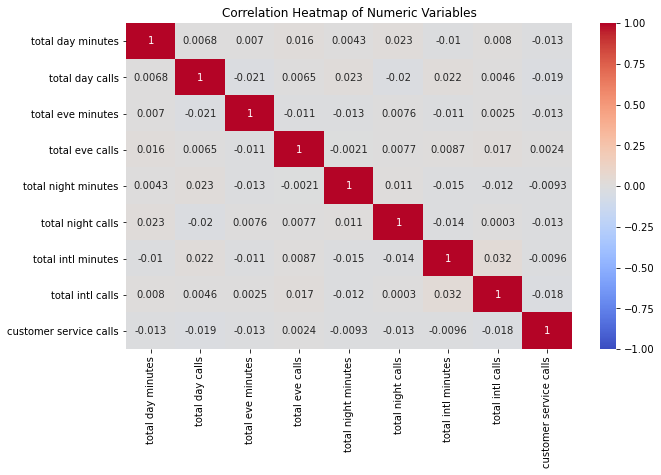

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

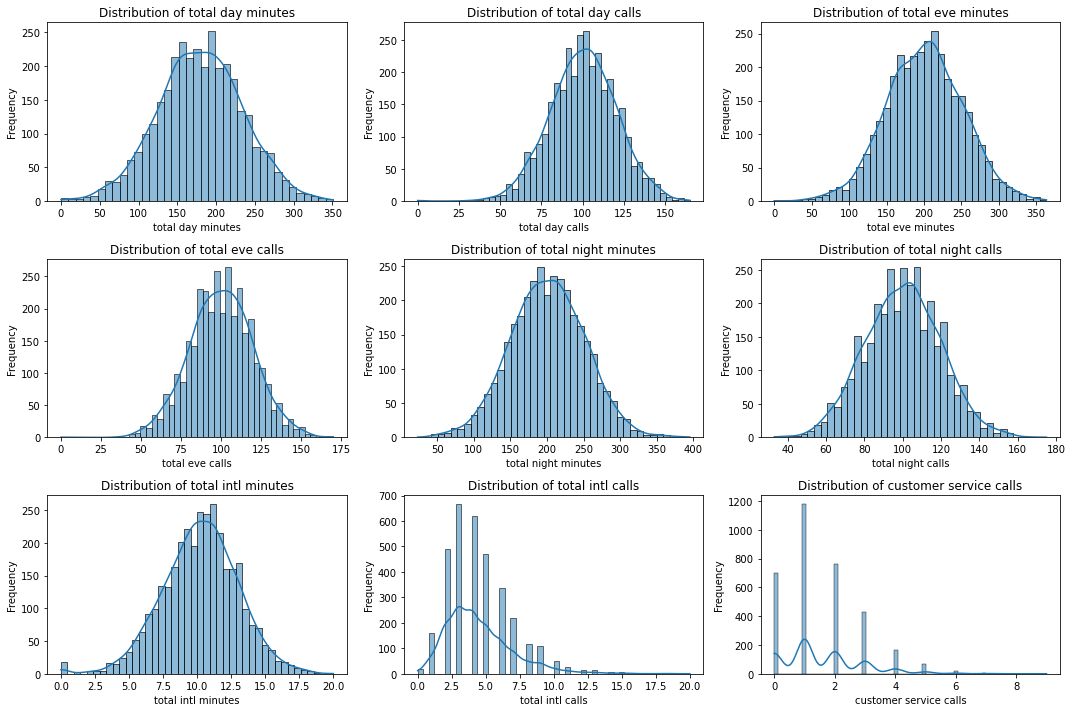

In [ ]:
# Distribution of numerical features
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_numerical.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_numerical[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
   
   

### Check and Handle Class Imbalance in the target class

Before training a model, it's important to check if the dataset is imbalanced — that is, whether one class dominates the other.A highly imbalanced dataset can cause the model to be biased toward the majority class, leading to poor performance on the minority class 

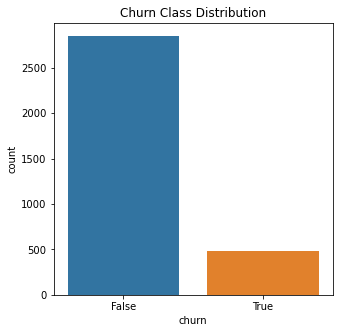

False    0.855086
True     0.144914
Name: churn, dtype: float64


In [ ]:
# Check for class imbalance in the target variable 'churn'
# plotting the distribution of the target variable 'churn'
plt.figure(figsize=(5, 5))
sns.countplot(x='churn', data=df)
plt.title('Churn Class Distribution')
plt.show()

print(df['churn'].value_counts(normalize=True))

From the plot above, 85.5% of customers did not churn, while only 14.5% did churn. This indicates a class imbalance in the dataset, which may require special handling during model training to ensure the minority class (churners) is not overlooked.

### Encode Categorical Variables

To prepare the dataset for modeling, categorical variables need to be converted into numeric format.

a) Binary Categories
Columns: international plan, voice mail plan
Values: 'yes', 'no'

These binary categories can be easily encoded by mapping 'yes' to 1 and 'no' to 0.

In [ ]:
df['international plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})
df['churn'] = df['churn'].astype(int)



In [ ]:
df.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Performing one hot encoding on categorical columns

In [ ]:
# one hot encoding for categorical variables
df_enconded = pd.get_dummies(df, columns=['international plan', 'voice mail plan'], drop_first=True)
df_enconded.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,international plan_1,voice mail plan_1
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,1,0


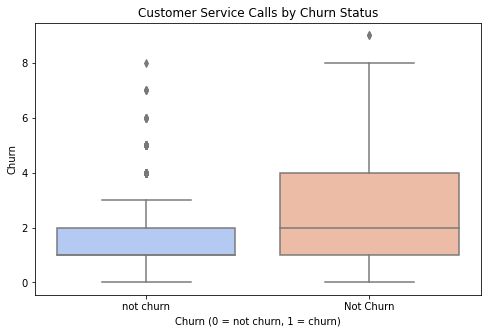

In [ ]:
# Box plot of customer service calls by churn status
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_enconded, x='churn', y='customer service calls', palette='coolwarm')
plt.title('Customer Service Calls by Churn Status')
plt.xlabel('Churn (0 = not churn, 1 = churn)')
plt.ylabel('Churn')
plt.xticks(ticks=[0, 1], labels=['not churn', 'Not Churn'])
plt.show()

## Modelling

### Splitting the Data

In [ ]:
# Split the dataset into features and target variable
X = df_enconded.drop(columns=['churn'])
y= df_enconded['churn']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42, stratify=y)

In [ ]:
# Check class balance
y_test.value_counts(normalize=True)

0    0.855
1    0.145
Name: churn, dtype: float64

### Handle Class Imbalance using SMOTE

In [ ]:
smote= SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Check the class distribution after resampling
print(y_train_resampled.value_counts(normalize=True))



0    0.5
1    0.5
Name: churn, dtype: float64


### Feature Scaling

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


### Train Logistic Regression Model

In [ ]:
#logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train_resampled)




LogisticRegression(random_state=42)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Logistic Regression - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Logistic Regression - Accuracy: 0.69, Precision: 0.29, Recall: 0.74, F1 Score: 0.41


### Evaluation Using Confusion Matrix


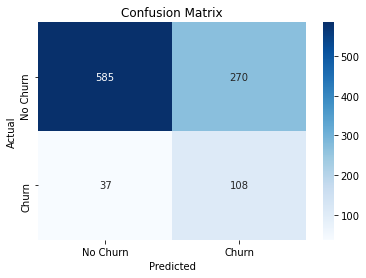

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.68      0.79       855
       Churn       0.29      0.74      0.41       145

    accuracy                           0.69      1000
   macro avg       0.61      0.71      0.60      1000
weighted avg       0.85      0.69      0.74      1000



 ### Add ROC Curve

In [ ]:
y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]  # probability of class 1 (churn)


Compute ROC Curve Values



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)


In [ ]:
# Cross-validation for Logistic Regression
cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
print(f'Logistic Regression Cross-Validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')

Logistic Regression Cross-Validation Accuracy: 0.73 ± 0.01


### Plot the ROC Curve

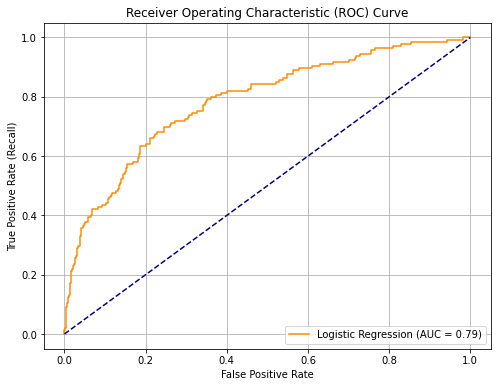

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_probs)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 0.7856


## Training Using Decision Trees

In [ ]:
# fittin a decision tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # You can tune depth later
dt_model.fit(X_train_resampled, y_train_resampled)

# fitting a random forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)  # You can tune n_estimators and depth later
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
# predicting with decision tree model
dt_y_pred = dt_model.predict(X_test_scaled)

# predicting with random forest model
rf_y_pred = rf_model.predict(X_test_scaled)


c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred) 
print(f'Decision Tree - Accuracy: {dt_accuracy:.2f}, Precision: {dt_precision:.2f}, Recall: {dt_recall:.2f}')

Decision Tree - Accuracy: 0.84, Precision: 0.42, Recall: 0.31


In [ ]:
# evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
print(f'Random Forest - Accuracy: {rf_accuracy:.2f}, Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}')

Random Forest - Accuracy: 0.86, Precision: 0.75, Recall: 0.04


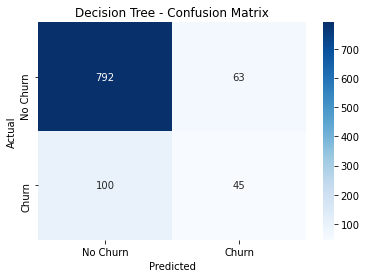

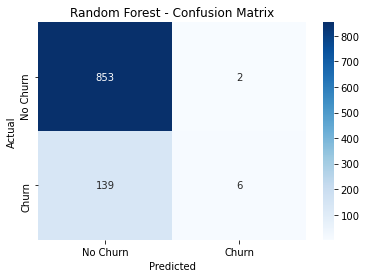

In [ ]:
# Function to plot confusion matrix
def plot_conf_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'], 
                yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot
plot_conf_matrix(confusion_matrix(y_test, dt_y_pred), 'Decision Tree - Confusion Matrix')
plot_conf_matrix(confusion_matrix(y_test, rf_y_pred), 'Random Forest - Confusion Matrix')


In [ ]:
# Classification Report for Decision Tree
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_y_pred, target_names=['No Churn', 'Churn']))
# Classification Report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred, target_names=['No Churn', 'Churn']))

Decision Tree Classification Report:
              precision    recall  f1-score   support

    No Churn       0.89      0.93      0.91       855
       Churn       0.42      0.31      0.36       145

    accuracy                           0.84      1000
   macro avg       0.65      0.62      0.63      1000
weighted avg       0.82      0.84      0.83      1000

Random Forest Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      1.00      0.92       855
       Churn       0.75      0.04      0.08       145

    accuracy                           0.86      1000
   macro avg       0.80      0.52      0.50      1000
weighted avg       0.84      0.86      0.80      1000



 ### Plotting ROC Comparison of Logistic Regression, Decision Tree, and Random Forest

In [ ]:
# Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1] )
roc_auc = auc(fpr, tpr)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])



c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


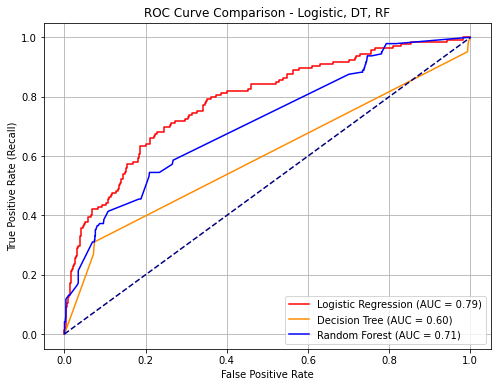

In [ ]:
plt.figure(figsize=(8,6))

# Logistic Regression
plt.plot(fpr, tpr, color='red', label='Logistic Regression (AUC = {:.2f})'.format(roc_auc))

# Decision Tree
plt.plot(fpr_dt, tpr_dt, color='darkorange', label='Decision Tree (AUC = {:.2f})'.format(roc_auc_dt))

# Random Forest
plt.plot(fpr_rf, tpr_rf, color='blue', label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison - Logistic, DT, RF')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(dt_model, X_train_scaled, y_train_resampled, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
print(f'Decision Tree Cross-Validation Accuracy: {np.mean(dt_cv_scores):.2f} ± {np.std(dt_cv_scores):.2f}')
# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train_resampled, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores):.2f} ± {np.std(rf_cv_scores):.2f}')



Decision Tree Cross-Validation Accuracy: 0.79 ± 0.01
Random Forest Cross-Validation Accuracy: 0.83 ± 0.01


These are mean accuracy scores obtained from cross-validation (e.g. 5-fold CV), where the model is trained and tested on different parts of the data.

0.79 means that, on average, the Decision Tree correctly classified 79% of the customers.

0.83 means that the Random Forest correctly classified 83% of the customers.

So, Random Forest is outperforming the Decision Tree by about 4 percentage points on average.

In [ ]:
# Parameter distributions for Decision Tree
dt_param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}

# Initialize model
dt = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV
dt_random_search = RandomizedSearchCV(
    dt, dt_param_dist, n_iter=50, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1
)

# Fit
dt_random_search.fit(X_train_scaled, y_train)

# Best model
best_dt = dt_random_search.best_estimator_
print("Best Decision Tree Params:", dt_random_search.best_params_)

ValueError: Found input variables with inconsistent numbers of samples: [3986, 2333]

### PR Curves for  Logistic regression, Decision Trees & Random Forest

In [ ]:
# PR curves
# Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_probs)
avg_precision_lr = average_precision_score(y_test, y_pred_probs)

# Decision Tree
y_probs_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_probs_dt)
avg_precision_dt = average_precision_score(y_test, y_probs_dt)

# Random Forest
y_probs_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)
avg_precision_rf = average_precision_score(y_test, y_probs_rf)


c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\anaconda31\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


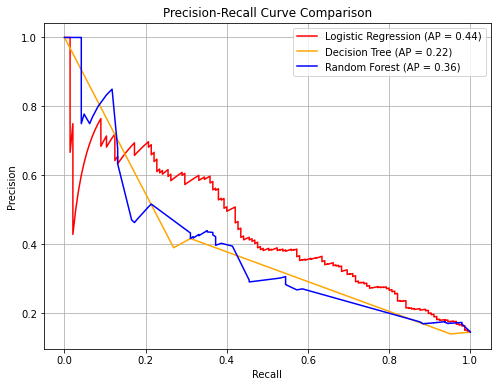

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(recall_lr, precision_lr, color='red', label='Logistic Regression (AP = {:.2f})'.format(avg_precision_lr))
plt.plot(recall_dt, precision_dt, color='orange', label='Decision Tree (AP = {:.2f})'.format(avg_precision_dt))
plt.plot(recall_rf, precision_rf, color='blue', label='Random Forest (AP = {:.2f})'.format(avg_precision_rf))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
